# LendingClub Investment Default Risk Analysis

This project uses historical LendingClub loan data to build a machine leaning model to identify the most important factors related to credit risk and to predict the default risk for each current loan. The moment new loans are added to the LendingClub platform, the algorithm analyzes the variables of these loans and recommends notes that are more likely to perform better than others.

**Table of Contents**

* <a href='#1'>1. Loading Data</a>
    * <a href='#1.1'>1.1 Import modulus</a>
    * <a href='#1.2'>1.2 Get Current Loan Data from Lending Club API</a>
    * <a href='#1.3'>1.3 Load Historical Data<a/>


* <a href='#2'>2. Data Preparation</a>
    * <a href='#2.1'>2.1 Find common and unique features<a/>
    * <a href='#2.2'>2.2 Clean historical data features</a>
    * <a href='#2.3'>2.3 Generate the target label </a>


* <a href='#3'>3. EDA and Feature Engineering</a>
    * <a href='#3.1'>3.1 Object features</a>
    * <a href='#3.2'>3.2 Numeric features</a>
    * <a href='#3.3'>3.3 Generate the cleaned dataset for modeling</a>


* <a href='#4'>4. XGBoost Modeling</a>
    * <a href='#4.1'>4.1 Generate training and testing sets</a>
    * <a href='#4.2'>4.2 XGBoost parameter tuning</a>
    * <a href='#4.3'>4.3 ROC curve</a>
    * <a href='#4.4'>4.4 Model accuracy</a>
    * <a href='#4.5'>4.5 Feature importance</a>
    * <a href='#4.6'>4.6 Performance on test data
    * <a href='#4.7'>4.7 Export trained model</a>


* <a href='#5'>5. Prediction on Current Loans</a>
    * <a href='#5.1'>5.1 Load the model</a>
    * <a href='#5.2'>5.2 Load the current data</a>
    * <a href='#5.3'>5.3 Data cleaning</a>
    * <a href='#5.4'>5.4 Predict the default rate </a>
    * <a href='#5.5'>5.5 Recommend loans based on investors' preference </a>

<a id='1'></a>
## 1. Loading Data

<a id='1.1'></a>
### 1.1 Import modulus

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import json
import requests
import re
from datetime import datetime
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

<a id='1.2'></a>
### 1.2  Get Current Loan Data Through LendingClub API

The following link provides instructions on LendingClub API:
* https://www.lendingclub.com/developers/api-overview

In [2]:
# API credential is stored in the file "apikey.txt"
api_key =open('apikey.txt','r').read()

headers = {'Authorization':api_key}
url='https://api.lendingclub.com/api/investor/v1/loans/listing?showAll=true'

r=requests.get(url, headers=headers)

In [3]:
data=r.json()
data.keys()    # r.json() has two keys: 'asOfDate', and 'loans'

dict_keys(['asOfDate', 'loans'])

In [4]:
# Under the key 'loans', the content is a list, and each element in the list is a dictionary
type(data['loans']), type(data['loans'][0])  

(list, dict)

In [5]:
# Read JSON file to a data frame
df_curr = pd.io.json.json_normalize(data['loans'])

In [6]:
df_curr.shape

(265, 119)

<a id='1.3'></a>
### 1.3 Load Historical Data

* Data source:
    * LendingClub Statistics (https://www.lendingclub.com/info/download-data.action)
* Historical data used in this project:
    * LendingClub 2014 investment data (The data file version is April 18, 2018) 
    * Note: LendingClub constantly updates old data files, so the currently downloaded dataset may be slightly different from the one used here 
* 2014 Dataset contains 235,629 loans with 151 features (before any data cleaning processes)

In [87]:
df_hist = pd.read_csv('data/LoanStats3c_securev1.csv', skiprows=1)

# remove the last two rows (which are not investment data but some summary information)
df_hist = df_hist.iloc[:-2, :]

In [88]:
df_hist.shape

(235629, 151)

<a id='2'></a>
## 2. Data Preparation

* Historical loan data and current loan data have many different features. Even for the same features they use different names. We first find the common features from these two datasets and change them to the same names.  

<a id='2.1'></a>
### 2.1 Find common and unique features

In [91]:
historical_feature = list(df_hist.columns.values)
current_feature = list(df_curr.columns.values)

In [92]:
# historical feature names: delete underscore(_)
for i in range(len(historical_feature)):
    historical_feature[i] = str(historical_feature[i]).replace('_','')

In [93]:
# current feature names: change uppercase to lowercase
for i in range(len(current_feature)):
    current_feature[i] = str.lower(current_feature[i])

In [94]:
# Find the common feature names in both historical and current dataset
common_feature = set(historical_feature)&(set(current_feature))
print("%d common feature names" %len(common_feature))

101 common feature names


In [95]:
# Find the unique feature names only in historical dataset
historical_unique = set(historical_feature)-set(current_feature)
print("%d unique feature names in the historical dataset\n" %len(historical_unique))
print(sorted(historical_unique))

50 unique feature names in the historical dataset

['collectionrecoveryfee', 'debtsettlementflag', 'debtsettlementflagdate', 'deferralterm', 'fundedamnt', 'fundedamntinv', 'hardshipamount', 'hardshipdpd', 'hardshipenddate', 'hardshipflag', 'hardshiplastpaymentamount', 'hardshiplength', 'hardshiploanstatus', 'hardshippayoffbalanceamount', 'hardshipreason', 'hardshipstartdate', 'hardshipstatus', 'hardshiptype', 'issued', 'lastcreditpulld', 'lastficorangehigh', 'lastficorangelow', 'lastpymntamnt', 'lastpymntd', 'loanamnt', 'loanstatus', 'nextpymntd', 'numacctsever120pd', 'origprojectedadditionalaccruedinterest', 'outprncp', 'outprncpinv', 'paymentplanstartdate', 'policycode', 'pymntplan', 'recoveries', 'settlementamount', 'settlementdate', 'settlementpercentage', 'settlementstatus', 'settlementterm', 'title', 'totalpymnt', 'totalpymntinv', 'totalrecint', 'totalreclatefee', 'totalrecprncp', 'url', 'verificationstatus', 'verificationstatusjoint', 'zipcode']


In [96]:
# Find the unique feature names only in current dataset
current_unique = set(current_feature)-set(historical_feature)
print("%d unique feature names in the current dataset\n" %len(current_unique))
print(sorted(current_unique))

18 unique feature names in the current dataset

['acceptd', 'addrzip', 'creditpulld', 'expd', 'expdefaultrate', 'fundedamount', 'housingpayment', 'ilsexpd', 'investorcount', 'isincv', 'isincvjoint', 'listd', 'loanamount', 'mtgpayment', 'numacctsever120ppd', 'reviewstatus', 'reviewstatusd', 'servicefeerate']


In [97]:
# The following features have different names but the same meanings
# thus we change historical feature names to current feature names
name_change = {
     'fundedamnt': 'fundedamount',
     'loanamnt': 'loanamount',
     'numacctsever120pd':  'numacctsever120ppd',
     'verificationstatus': 'isincv',
     'verificationstatusjoint': 'isincvjoint',
     'zipcode': 'addrzip'
}

In [98]:
for key, value in name_change.items():
    common_feature = common_feature.union({value})
print("The number of total common features is %d" %len(common_feature))

The number of total common features is 107


<a id='2.2'></a>
### 2.2 Clean historical data feature names

* Remove underscores from feature names
* Rename feature names from "name_change" dictionary
* Remove feature names with empty data
* Only choose loans with term=36 months
* Seperate features to object features and numeric features

In [99]:
# remove underscore from feature names
for i in range(len(df_hist.columns.values)):
    df_hist.columns.values[i] = str(df_hist.columns.values[i]).replace('_', '')

In [100]:
# rename feature names from "name_change" dictionary
df_hist.rename(columns=name_change, inplace=True)

In [102]:
# only choose features from the "common_feature" list + target feature "loanstatus"
df_hist = df_hist[list(common_feature) + ['issued'] + ['loanstatus']]

In [103]:
# find features without any data
empty_features = list(df_hist.columns.values[df_hist.isnull().sum() == df_hist.shape[0]])
print("%d features without any data\n" %len(empty_features))
print(sorted(empty_features))

31 features without any data

['allutil', 'annualincjoint', 'dtijoint', 'ilutil', 'inqfi', 'inqlast12m', 'isincvjoint', 'maxbalbc', 'memberid', 'mthssincercntil', 'openacc6m', 'openactil', 'openil12m', 'openil24m', 'openrv12m', 'openrv24m', 'revolbaljoint', 'secappchargeoffwithin12mths', 'secappcollections12mthsexmed', 'secappearliestcrline', 'secappficorangehigh', 'secappficorangelow', 'secappinqlast6mths', 'secappmortacc', 'secappmthssincelastmajorderog', 'secappnumrevaccts', 'secappopenacc', 'secappopenactil', 'secapprevolutil', 'totalbalil', 'totalcutl']


In [104]:
# remove feature names with empty data from the list of "common_feature"
common_feature = common_feature - set(empty_features)

In [105]:
# remove features with empty data 
df_hist.drop(list(empty_features), axis=1, inplace=True)

In [106]:
# only choose '36 months' loans
df_hist = df_hist[df_hist['term']==' 36 months']

In [107]:
# Seperate object features and numerical features to two sets
fn_obj = []
fn_num = []
for col in df_hist.columns.values:
    if df_hist[col].dtype == 'O':
        fn_obj.append(col)
    else:
        fn_num.append(col)

In [108]:
print("%d object features\n" %len(fn_obj))
print(sorted(fn_obj))

20 object features

['addrstate', 'addrzip', 'applicationtype', 'desc', 'disbursementmethod', 'earliestcrline', 'emplength', 'emptitle', 'grade', 'homeownership', 'id', 'initialliststatus', 'intrate', 'isincv', 'issued', 'loanstatus', 'purpose', 'revolutil', 'subgrade', 'term']


In [109]:
# "applicationtype" only "individual"
# "desc" majority missing, delete
# "disbursementmethod" only "cash"
# "id" is useless 
# "loanstatus" is the target feature
# "term" only 36 months
fn_obj_remove = ['applicationtype', 'desc', 'disbursementmethod', 'id', 'loanstatus', 'term']   

fn_obj = [x for x in fn_obj if x not in fn_obj_remove]
print("%d object features\n" %len(fn_obj))
print(fn_obj)

14 object features

['addrzip', 'purpose', 'subgrade', 'emptitle', 'grade', 'initialliststatus', 'homeownership', 'isincv', 'intrate', 'addrstate', 'earliestcrline', 'emplength', 'revolutil', 'issued']


In [110]:
fn_num.sort()
print("%d numerical features\n" %len(fn_num))
print(fn_num)

58 numerical features

['accnowdelinq', 'accopenpast24mths', 'annualinc', 'avgcurbal', 'bcopentobuy', 'bcutil', 'chargeoffwithin12mths', 'collections12mthsexmed', 'delinq2yrs', 'delinqamnt', 'dti', 'ficorangehigh', 'ficorangelow', 'fundedamount', 'inqlast6mths', 'installment', 'loanamount', 'mortacc', 'mosinoldilacct', 'mosinoldrevtlop', 'mosinrcntrevtlop', 'mosinrcnttl', 'mthssincelastdelinq', 'mthssincelastmajorderog', 'mthssincelastrecord', 'mthssincerecentbc', 'mthssincerecentbcdlq', 'mthssincerecentinq', 'mthssincerecentrevoldelinq', 'numacctsever120ppd', 'numactvbctl', 'numactvrevtl', 'numbcsats', 'numbctl', 'numiltl', 'numoprevtl', 'numrevaccts', 'numrevtlbalgt0', 'numsats', 'numtl120dpd2m', 'numtl30dpd', 'numtl90gdpd24m', 'numtloppast12m', 'openacc', 'pcttlnvrdlq', 'percentbcgt75', 'pubrec', 'pubrecbankruptcies', 'revolbal', 'taxliens', 'totalacc', 'totalbalexmort', 'totalbclimit', 'totalilhighcreditlimit', 'totalrevhilim', 'totcollamt', 'totcurbal', 'tothicredlim']


<a id='2.3'></a>
### 2.3 Generate the target label 

* Only choose 'Fully Paid' and 'Charged Off' loans
* Label the target variable: 'Fully Paid' = 0, 'Charged Off' = 1

In [111]:
# only choose 'Fully Paid' and 'Charged Off' loans
loan_status = ['Fully Paid', 'Charged Off']
df_hist = df_hist[df_hist['loanstatus'].isin(loan_status)]

In [112]:
df_hist['loanstatus'] = df_hist.loanstatus.map({"Charged Off": 1, "Fully Paid": 0})

In [113]:
# Distribution of the binary label
df_hist['loanstatus'].value_counts(normalize=True)

0    0.862765
1    0.137235
Name: loanstatus, dtype: float64

<a id='3'></a>
## 3. EDA and Feature Engineering

<a id='3.1'></a>
### 3.1 Object features

In [114]:
def fn_obj_eda(featue_name, normalize=True):
    """
    Return number of missing values, and compute a histogram of the counts of non-null values.
    @params:
        feature_name      - Required: the feature's name (Str)
        norm                   - Optional:  If True then compute a relative histogram (Boolean)
    """
    print("Feature Name: ", featue_name)
    print("Null Values:", df_hist[featue_name].isnull().sum())
    print(df_hist[featue_name].value_counts(normalize=normalize))

In [115]:
def plot_cat(cat, figw=5, figh=3, rot=0):
    """
    Plot a barplot for categorical feature.
    @params:
        cat                       - Required: the categorical feature's name (Str)
        figw                     - Optional:  figure's width (int)
        figh                      - Optional: figure's height (int)
        rot                        - Optional: the rotation angle of the x tick lables
    """
    fig, ax = plt.subplots(figsize=(figw, figh))
    g = sns.barplot(df_hist[cat], df_hist.loanstatus, ax=ax)
    g.set_xticklabels(g.get_xticklabels(), rotation=rot)

<a id='3.1.1'></a>
#### 3.1.1  "addrstate": frequency encoding

* Use the relative frequency to transform "addrstate" feature to a numeric feature

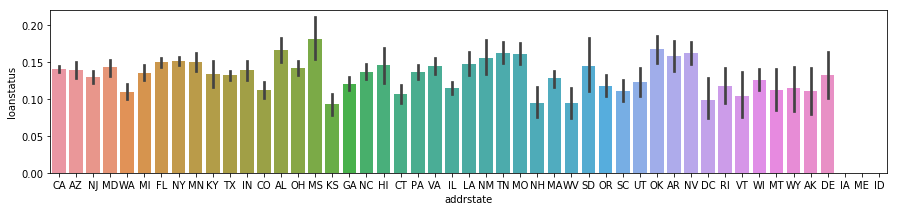

In [116]:
plot_cat('addrstate', figw=15)

In [117]:
# get frequency for each state
addrstate_freq = df_hist.groupby("addrstate").size().reset_index()
addrstate_freq.columns = ["addrstate", "addrstate_freq"]
addrstate_freq['addrstate_freq'] = addrstate_freq['addrstate_freq']/df_hist.shape[0]
addrstate_freq.head()

,addrstate,addrstate_freq
0,AK,0.002559
1,AL,0.011898
2,AR,0.007641
3,AZ,0.023926
4,CA,0.149711


In [118]:
addrstate_freq.to_csv('data/model_addrstate_freq.csv', index=False)

In [119]:
df_hist = pd.merge(df_hist, addrstate_freq, how = "left", on = "addrstate")

In [120]:
fn_obj.remove('addrstate')
fn_num.append('addrstate_freq')

<a id='3.1.2'></a>
#### 3.1.2  Features to remove: 'addrzip', 'emptitle', 'grade', 'subgrade', 'earliestcrline', 'initialliststatus'

The reasons to remove following object features:
* "addrzip": too many levels
* "emptitle": too many levels with many missing values
* "grade" and "subgrade": highly related with the numeric feature "intrate"
* "earliestcrline": highly related with "mosinoldrevtlop" (Months since oldest revolving account opened)
* "initialliststatus": there are only two levels "w" and "f" in the historical dataset, but only one level "f" in the current dataset 

In [121]:
fn_obj_remove = ['addrzip', 'emptitle', 'grade', 'subgrade', 'earliestcrline', 'initialliststatus']
fn_obj = list(set(fn_obj)-set(fn_obj_remove))

In [123]:
print(fn_obj)

['issued', 'intrate', 'homeownership', 'isincv', 'emplength', 'revolutil', 'purpose']


<a id='3.1.3'></a>
#### 3.1.3 "intrate": transform to numeric feature

In [124]:
df_hist['intrate'].value_counts().head()

 12.99%    9836
 10.99%    9538
 12.49%    8306
 13.98%    6085
 11.67%    6026
Name: intrate, dtype: int64

In [125]:
df_hist['intrate'] = df_hist['intrate'].apply(lambda x: x.replace('%', '')).astype(float)

In [126]:
fn_obj.remove('intrate')
fn_num.append('intrate')

<a id='3.1.4'></a>
#### 3.1.4 "revolutil": transform to numeric feature

In [127]:
df_hist['revolutil'].value_counts().head()

0%     431
59%    385
48%    375
58%    374
53%    373
Name: revolutil, dtype: int64

In [128]:
df_hist['revolutil'] = df_hist['revolutil'].apply(lambda x: str(x).replace('%', '')).astype(float)

In [129]:
# Filling missing values with the median value
df_hist.revolutil.fillna(df_hist.revolutil.median(), inplace=True)

In [130]:
fn_obj.remove('revolutil')
fn_num.append('revolutil')

<a id='3.1.5'></a>
#### 3.1.5 "emplength": transform to numeric features

* In the current loan data, "emplength" uses numeric months instead of strings as in the historical data. Thus, transform historical data to follow the current data.

In [131]:
df_curr['empLength'].unique()

array([120.,  48.,  nan,  72.,  84.,  36.,  60.,   0.,  96.,  24.,  12.,
       108., 240., 144., 216., 156., 228., 252., 180.])

In [132]:
df_hist['emplength'].unique()

array(['8 years', '< 1 year', '10+ years', '2 years', '9 years',
       '7 years', '1 year', '5 years', '3 years', '4 years', nan,
       '6 years'], dtype=object)

In [133]:
emplength_text = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
emplength_num = [0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120]
emplength_tbl = pd.DataFrame({'emplength': emplength_text, 'emplength_num': emplength_num})
emplength_tbl.head()

,emplength,emplength_num
0,< 1 year,0
1,1 year,12
2,2 years,24
3,3 years,36
4,4 years,48


In [134]:
df_hist = pd.merge(df_hist, emplength_tbl, how = "left", on = "emplength")

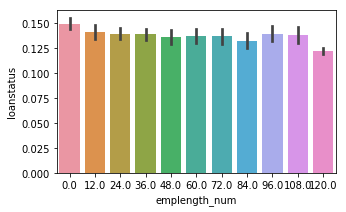

In [135]:
plot_cat('emplength_num')

In [136]:
df_hist.drop('emplength', axis=1, inplace=True)

In [137]:
df_hist.rename(columns={'emplength_num': 'emplength'}, inplace=True)

In [138]:
fn_obj.remove('emplength')
fn_num.append('emplength')

<a id='3.1.6'></a>
#### 3.1.6 "issued"

* There are no significant differences in charge-off rate on issue month.
* We will use loans issued in Jan to Oct to be the training data, and loans issued in Nov and Dec to be the test data.

In [171]:
fn_obj_eda('issued')

Feature Name:  issued
Null Values: 0
Oct-2014    0.163469
Jul-2014    0.122680
Nov-2014    0.101886
Aug-2014    0.081719
Apr-2014    0.081608
May-2014    0.080642
Mar-2014    0.071586
Jun-2014    0.070799
Jan-2014    0.070719
Feb-2014    0.067323
Sep-2014    0.045341
Dec-2014    0.042228
Name: issued, dtype: float64


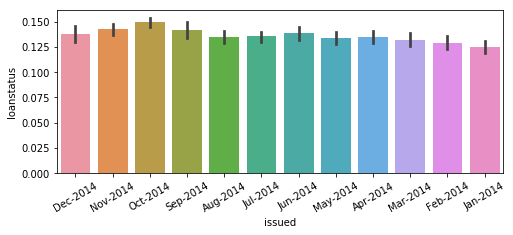

In [151]:
plot_cat('issued', figw=8, rot=30)

In [172]:
df_hist.loc[df_hist.issued.isin(['Dec-2014', 'Nov-2014', 'Oct-2014']), 'loanstatus'].value_counts(normalize=True)

0    0.854808
1    0.145192
Name: loanstatus, dtype: float64

In [164]:
fn_obj.remove('issued')

<a id='3.1.7'></a>
#### 3.1.7 One Hot Encoding: "homeownership", "isincv", "purpose"

In [165]:
# Histogram for "homeownership"
fn_obj_eda('homeownership', normalize=False)

Feature Name:  homeownership
Null Values: 0
MORTGAGE    76316
RENT        69738
OWN         16491
Name: homeownership, dtype: int64


In [166]:
# "homeownership": remove ANY
df_hist = df_hist[df_hist.homeownership.isin(['MORTGAGE', 'RENT', 'OWN'])]

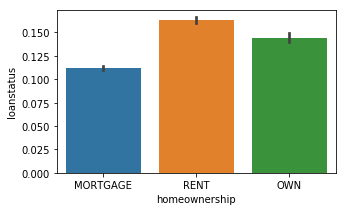

In [167]:
plot_cat('homeownership')

In [168]:
# Histogram for "isincv"
fn_obj_eda('isincv')

Feature Name:  isincv
Null Values: 0
NOT_VERIFIED       0.374149
SOURCE_VERIFIED    0.364225
VERIFIED           0.261626
Name: isincv, dtype: float64


In [169]:
# Change the value to follow current data's manner
df_hist.loc[df_hist.isincv=='Not Verified', 'isincv'] = 'NOT_VERIFIED'
df_hist.loc[df_hist.isincv=='Source Verified', 'isincv'] = 'SOURCE_VERIFIED'
df_hist.loc[df_hist.isincv=='Verified', 'isincv'] = 'VERIFIED'

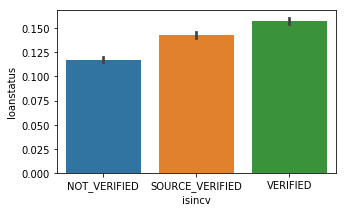

In [170]:
plot_cat('isincv')

In [173]:
# Histogram for "purpose"
fn_obj_eda('purpose', normalize=True)

Feature Name:  purpose
Null Values: 0
debt_consolidation    0.583266
credit_card           0.246664
rest                  0.066068
home_improvement      0.053234
other                 0.050767
Name: purpose, dtype: float64


In [174]:
# Keep categories with more than 5% of the data, and generate a new category named "rest" for the rest of the data
purpose_cat = ['credit_card', 'debt_consolidation', 'home_improvement', 'other']
df_hist.loc[~df_hist.purpose.isin(purpose_cat), 'purpose'] = 'rest'

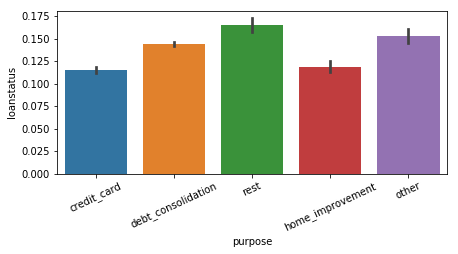

In [175]:
plot_cat('purpose', figw=7, rot=25)

In [176]:
# One hot encoding
df_dummy = pd.get_dummies(df_hist[fn_obj])
fn_OHE = list(df_dummy.columns.values)
fn_OHE

['homeownership_MORTGAGE',
 'homeownership_OWN',
 'homeownership_RENT',
 'isincv_NOT_VERIFIED',
 'isincv_SOURCE_VERIFIED',
 'isincv_VERIFIED',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_home_improvement',
 'purpose_other',
 'purpose_rest']

In [177]:
df_hist = pd.concat([df_hist, df_dummy], axis=1 )

<a id='3.2'></a>
### 3.2 Numeric features

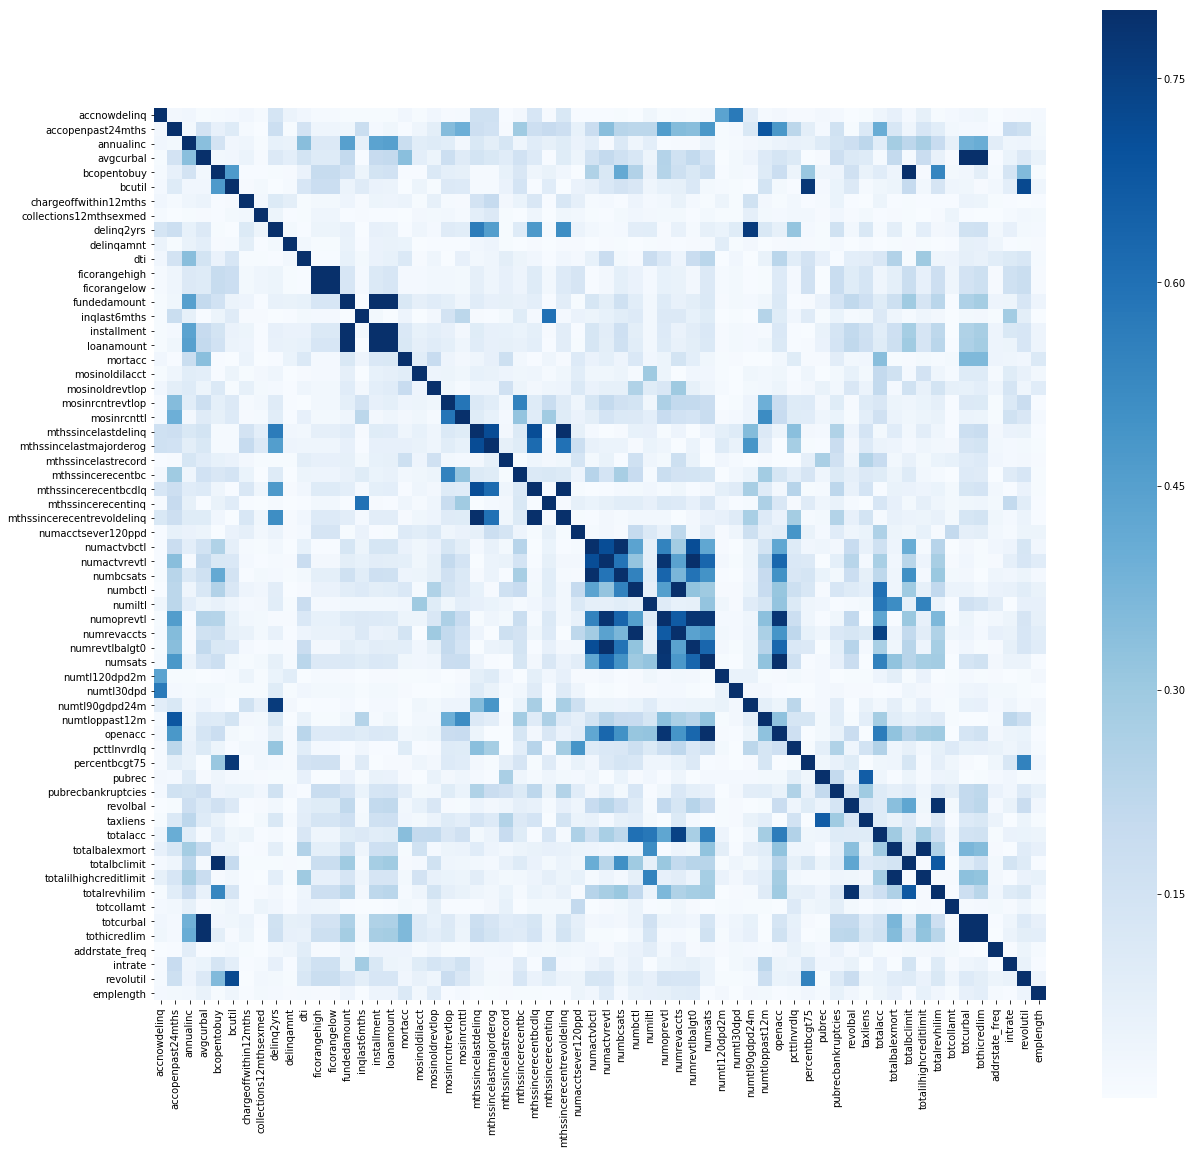

In [180]:
# Correlation matrix and heatmap
corrmat = df_hist[fn_num].dropna().corr().abs()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, square=True, cmap="Blues");

In [181]:
def get_top_abs_correlations(df, threshold=0.9):
    """
    Return the absolute correlations along with two feature names above the given threshold.
    @params:
        df                        - Required: the data frame
        threshold            - Optional:  only return correlations high than or equal to the threshold (float)
    """
    au_corr = df.dropna().corr().abs().unstack()
    labels_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            labels_to_drop.add((cols[i], cols[j]))    
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    top_corr = pd.DataFrame(au_corr[au_corr>=threshold], columns={'correlation'}).reset_index()
    return top_corr

In [182]:
top_corr = get_top_abs_correlations(df_hist[fn_num], threshold=0.88)
top_corr

,level_0,level_1,correlation
0,fundedamount,loanamount,1.000000
1,ficorangehigh,ficorangelow,1.000000
2,numactvrevtl,numrevtlbalgt0,0.999037
3,numsats,openacc,0.996749
4,fundedamount,installment,0.995891
5,installment,loanamount,0.995891
6,totcurbal,tothicredlim,0.985590
7,totalbalexmort,totalilhighcreditlimit,0.911599
8,avgcurbal,totcurbal,0.885170
9,mthssincerecentbcdlq,mthssincerecentrevoldelinq,0.884292


In [183]:
# For the highly correlated features, only keep the features with higher correlation with the target variable "loanstatus"
# and remove the featurs with lower correlation with "loanstatus"
fn_nu_remove = []
for row_idx in range(len(top_corr)):
    level0 = np.abs(df_hist['loanstatus'].corr(df_hist[top_corr.iloc[row_idx, 0]]))
    level1 = np.abs(df_hist['loanstatus'].corr(df_hist[top_corr.iloc[row_idx, 1]]))
    if level0 > level1:
        fn_nu_remove.append(top_corr.iloc[row_idx, 1])
    else:
        fn_nu_remove.append(top_corr.iloc[row_idx, 0])
    fn_nu_remove = list(set(fn_nu_remove))

In [184]:
print("Remove the following features who are highly correlated with other features:")
sorted(fn_nu_remove)

Remove the following features who are highly correlated with other features:


['avgcurbal',
 'ficorangehigh',
 'fundedamount',
 'installment',
 'mthssincerecentrevoldelinq',
 'numactvrevtl',
 'openacc',
 'totalilhighcreditlimit',
 'totcurbal']

In [185]:
fn_num = list(set(fn_num) - set(fn_nu_remove))
print("The number of numeric features is %d" %len(fn_num))

The number of numeric features is 53


<a id='3.3'></a>
### 3.3 Generate the cleaned dataset for modeling

* The cleaned dataset has 162,545 loans with 64 features and 1 target label (loan status)

In [186]:
select_feature = fn_num + fn_OHE 

In [187]:
len(select_feature)

64

In [188]:
other_feature = ['grade', 'subgrade', 'issued']

In [189]:
target = ['loanstatus']

In [190]:
# Generate the cleaned dataset for modeling
df_hist = df_hist[select_feature + other_feature + target]

In [191]:
df_hist.shape

(162545, 68)

<a id='4'></a>
## 4. XGBoost Modeling

We chose to use XGBoost machine learning algorithm to train the model. XGBoost is an implementation of gradient boosted (GBM) decision trees designed for speed and performance. 

<a id='4.1'></a>
### 4.1 Generate training and testing sets

In [336]:
test_issued = ['Dec-2014', 'Nov-2014']
df_test = df_hist[df_hist.issued.isin(test_issued)]
test_x = df_test[select_feature]
test_y = df_test[target]
df_train = df_hist[~df_hist.issued.isin(test_issued)]
train_x = df_train[select_feature]
train_y = df_train[target]

In [337]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((139120, 64), (23425, 64), (139120, 1), (23425, 1))

In [235]:
# Let XGBoost's in-built routine to handle missing values
xgbtrain = xgb.DMatrix(train_x, label=train_y.values.reshape(train_x.shape[0], 1), missing=np.nan)
xgbtest = xgb.DMatrix(test_x, label=test_y.values.reshape(test_x.shape[0], 1), missing=np.nan)

<a id='4.2'></a>
### 4.2 XGBoost parameter tuning

In [236]:
score_names = ['score', 'eta', 'max_depth', 'min_child_weight', 'colsample_bytree', 'subsample', 'gamma', 'reg_alpha', 'reg_lambda', 'best_iteration']
scores = pd.DataFrame([], columns=score_names)

In [237]:
def xgb_param_tuning(param_name, param_value):
    """
    Use cross validation to train the xgboost model with the given parameter value and return the AUC scores.
    @params:
        param_name      - Required: the parameter's name (str)
        param_value       - Required: the parameter's value (float)
    """
    params[param_name] = param_value
    
    cv_results = xgb.cv(params, xgbtrain,
                        num_boost_round=10000,
                        nfold=5,
                        metrics={'auc'},
                        stratified=True,
                        shuffle=True,
                        seed=42,
                        early_stopping_rounds=50)
    
    best_iteration = len(cv_results)
    best_score = cv_results['test-auc-mean'].max()
    print(param_name, ':', param_value, ', best_score: ', best_score, ', best_iteration: ', best_iteration)
    new_score = pd.DataFrame([[best_score, params['eta'], params['max_depth'], params['min_child_weight'], params['colsample_bytree'], 
                   params['subsample'], params['gamma'], params['reg_alpha'], params['reg_lambda'], best_iteration]], columns=score_names)
    return new_score 

<a id='4.2.1'></a>
#### 4.2.1 max_depth

In [238]:
params = dict()
params['objective'] = 'binary:logistic'
params['eta'] = 0.1
params['min_child_weight'] = 1
params['colsample_bytree'] = 1
params['subsample'] = 1
params['gamma'] = 0
params['reg_alpha'] = 0
params['reg_lambda'] = 1
params['seed'] = 42

for max_depth in [3, 4, 5, 6, 7, 8]:
    new_score = xgb_param_tuning('max_depth', max_depth)
    scores = pd.concat([scores, new_score])   

best_max_depth = scores.sort_values(by='score', ascending=False)['max_depth'].values[0]
print('best max_depth is', best_max_depth)

max_depth : 3 , best_score:  0.6907528 , best_iteration:  432
max_depth : 4 , best_score:  0.6897304 , best_iteration:  209
max_depth : 5 , best_score:  0.6895248 , best_iteration:  133
max_depth : 6 , best_score:  0.6887373999999999 , best_iteration:  112
max_depth : 7 , best_score:  0.6870493999999999 , best_iteration:  67
max_depth : 8 , best_score:  0.6854404 , best_iteration:  66
best max_depth is 3


In [239]:
#best_max_depth = 3

<a id='4.2.2'></a>
#### 4.2.2 min_child_weight

In [240]:
params = dict()
params['objective'] = 'binary:logistic'
params['eta'] = 0.1
params['colsample_bytree'] = 1
params['subsample'] = 1
params['gamma'] = 0
params['reg_alpha'] = 0
params['reg_lambda'] = 1
params['seed'] = 42
params['max_depth'] = best_max_depth


for min_child_weight in [1, 10, 20, 30, 40, 50, 70, 100, 120, 150, 170, 200]:
    new_score = xgb_param_tuning('min_child_weight', min_child_weight)
    scores = pd.concat([scores, new_score])   

best_min_child_weight = scores.sort_values(by='score', ascending=False)['min_child_weight'].values[0]
print('best min_child_weight is', best_min_child_weight)

min_child_weight : 1 , best_score:  0.6907528 , best_iteration:  432
min_child_weight : 10 , best_score:  0.6916312 , best_iteration:  355
min_child_weight : 20 , best_score:  0.6912228 , best_iteration:  380
min_child_weight : 30 , best_score:  0.6913374 , best_iteration:  367
min_child_weight : 40 , best_score:  0.6914478 , best_iteration:  365
min_child_weight : 50 , best_score:  0.6916906 , best_iteration:  343
min_child_weight : 70 , best_score:  0.6923980000000001 , best_iteration:  412
min_child_weight : 100 , best_score:  0.6922134 , best_iteration:  382
min_child_weight : 120 , best_score:  0.6930069999999999 , best_iteration:  451
min_child_weight : 150 , best_score:  0.6926653999999999 , best_iteration:  432
min_child_weight : 170 , best_score:  0.6921676000000001 , best_iteration:  395
min_child_weight : 200 , best_score:  0.6919992 , best_iteration:  459
best min_child_weight is 120


In [241]:
#best_min_child_weight=120

<a id='4.2.3'></a>
#### 4.2.3 colsample_bytree

In [242]:
params = dict()
params['objective'] = 'binary:logistic'
params['eta'] = 0.1
params['subsample'] = 1
params['gamma'] = 0
params['reg_alpha'] = 0
params['reg_lambda'] = 1
params['seed'] = 42
params['max_depth'] = best_max_depth
params['min_child_weight'] = best_min_child_weight


for colsample_bytree in [0.1, 0.3, 0.5, 0.7, 0.9, 1]:
    new_score = xgb_param_tuning('colsample_bytree', colsample_bytree)
    scores = pd.concat([scores, new_score])       

best_colsample_bytree = scores.sort_values(by='score', ascending=False)['colsample_bytree'].values[0]
print('best colsample_bytree is', best_colsample_bytree)

colsample_bytree : 0.1 , best_score:  0.6914436 , best_iteration:  474
colsample_bytree : 0.3 , best_score:  0.692388 , best_iteration:  477
colsample_bytree : 0.5 , best_score:  0.6924695999999999 , best_iteration:  370
colsample_bytree : 0.7 , best_score:  0.6926234000000001 , best_iteration:  401
colsample_bytree : 0.9 , best_score:  0.6923566000000001 , best_iteration:  339
colsample_bytree : 1 , best_score:  0.6930069999999999 , best_iteration:  451
best colsample_bytree is 1


In [243]:
#best_colsample_bytree=1

<a id='4.2.4'></a>
#### 4.2.4 subsample

In [244]:
params = dict()
params['objective'] = 'binary:logistic'
params['eta'] = 0.1
params['gamma'] = 0
params['reg_alpha'] = 0
params['reg_lambda'] = 1
params['seed'] = 42
params['max_depth'] = best_max_depth
params['min_child_weight'] = best_min_child_weight
params['colsample_bytree'] = best_colsample_bytree


for subsample in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    new_score = xgb_param_tuning('subsample', subsample)
    scores = pd.concat([scores, new_score])       

    
best_subsample = scores.sort_values(by='score', ascending=False)['subsample'].values[0]
print('best subsample is', best_subsample)

subsample : 0.5 , best_score:  0.692067 , best_iteration:  321
subsample : 0.6 , best_score:  0.6922544 , best_iteration:  306
subsample : 0.7 , best_score:  0.6922416 , best_iteration:  317
subsample : 0.8 , best_score:  0.6925584 , best_iteration:  348
subsample : 0.9 , best_score:  0.6922514000000001 , best_iteration:  365
subsample : 1 , best_score:  0.6930069999999999 , best_iteration:  451
best subsample is 1


In [245]:
#best_subsample=1

<a id='4.2.5'></a>
#### 4.2.5 gamma

In [246]:
params = dict()
params['objective'] = 'binary:logistic'
params['eta'] = 0.1
params['reg_alpha'] = 0
params['reg_lambda'] = 1
params['seed'] = 42
params['max_depth'] = best_max_depth
params['min_child_weight'] = best_min_child_weight
params['colsample_bytree'] = best_colsample_bytree
params['subsample'] = best_subsample


for gamma in  [0, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 2]:
    new_score = xgb_param_tuning('gamma', gamma)
    scores = pd.concat([scores, new_score])       

    
best_gamma = scores.sort_values(by='score', ascending=False)['gamma'].values[0]
print('best gamma is', best_gamma)

gamma : 0 , best_score:  0.6930069999999999 , best_iteration:  451
gamma : 0.1 , best_score:  0.6930069999999999 , best_iteration:  451
gamma : 0.3 , best_score:  0.6930069999999999 , best_iteration:  451
gamma : 0.5 , best_score:  0.6930069999999999 , best_iteration:  451
gamma : 0.7 , best_score:  0.6930069999999999 , best_iteration:  451
gamma : 1 , best_score:  0.6930069999999999 , best_iteration:  451
gamma : 1.5 , best_score:  0.692992 , best_iteration:  449
gamma : 2 , best_score:  0.6929869999999999 , best_iteration:  429
best gamma is 1


In [247]:
#best_gamma=1

<a id='4.2.6'></a>
#### 4.2.6 reg_alpha

In [248]:
params = dict()
params['objective'] = 'binary:logistic'
params['eta'] = 0.1
params['reg_lambda'] = 1
params['seed'] = 42
params['max_depth'] = best_max_depth
params['min_child_weight'] = best_min_child_weight
params['colsample_bytree'] = best_colsample_bytree
params['subsample'] = best_subsample
params['gamma'] = best_gamma

for reg_alpha in  [0, 0.5, 1, 1.5, 2, 2.2, 2.5, 2.8, 3]:
    new_score = xgb_param_tuning('reg_alpha', reg_alpha)
    scores = pd.concat([scores, new_score])       

    
best_reg_alpha = scores.sort_values(by='score', ascending=False)['reg_alpha'].values[0]
print('best reg_alpha is', best_reg_alpha)

reg_alpha : 0 , best_score:  0.6930069999999999 , best_iteration:  451
reg_alpha : 0.5 , best_score:  0.6923146000000001 , best_iteration:  359
reg_alpha : 1 , best_score:  0.6924114 , best_iteration:  383
reg_alpha : 1.5 , best_score:  0.6925051999999999 , best_iteration:  411
reg_alpha : 2 , best_score:  0.6925386 , best_iteration:  435
reg_alpha : 2.2 , best_score:  0.6923268 , best_iteration:  330
reg_alpha : 2.5 , best_score:  0.692531 , best_iteration:  456
reg_alpha : 2.8 , best_score:  0.6922090000000001 , best_iteration:  391
reg_alpha : 3 , best_score:  0.692395 , best_iteration:  451
best reg_alpha is 0


In [249]:
#best_reg_alpha=0

<a id='4.2.7'></a>
#### 4.2.7 reg_lambda

In [250]:
params = dict()
params['objective'] = 'binary:logistic'
params['eta'] = 0.1
params['reg_lambda'] = 1
params['seed'] = 42
params['max_depth'] = best_max_depth
params['min_child_weight'] = best_min_child_weight
params['colsample_bytree'] = best_colsample_bytree
params['subsample'] = best_subsample
params['gamma'] = best_gamma
params['reg_alpha'] = best_reg_alpha

for reg_lambda in  [0, 0.2, 0.5, 0.7, 1, 1.2, 1.5, 1.7, 2]:
    new_score = xgb_param_tuning('reg_lambda', reg_lambda)
    scores = pd.concat([scores, new_score])       

    
best_reg_lambda = scores.sort_values(by='score', ascending=False)['reg_lambda'].values[0]
print('best reg_lambda is', best_reg_lambda)

reg_lambda : 0 , best_score:  0.6922406000000001 , best_iteration:  338
reg_lambda : 0.2 , best_score:  0.6924372 , best_iteration:  435
reg_lambda : 0.5 , best_score:  0.6921628 , best_iteration:  416
reg_lambda : 0.7 , best_score:  0.692485 , best_iteration:  369
reg_lambda : 1 , best_score:  0.6930069999999999 , best_iteration:  451
reg_lambda : 1.2 , best_score:  0.6924572 , best_iteration:  374
reg_lambda : 1.5 , best_score:  0.6927892 , best_iteration:  492
reg_lambda : 1.7 , best_score:  0.6926460000000001 , best_iteration:  339
reg_lambda : 2 , best_score:  0.6921004 , best_iteration:  412
best reg_lambda is 1


In [251]:
#best_reg_lambda=1

In [252]:
params['reg_lambda'] = best_reg_lambda

<a id='4.2.8'></a>
#### 4.2.8 Train model with a smaller eta

In [253]:
params['eta'] = 0.01

cv_results = xgb.cv(params, xgbtrain,
                    num_boost_round=10000,
                    nfold=5,
                    metrics='auc',
                    stratified=True,
                    shuffle=True,
                    seed=42,
                    early_stopping_rounds=50)

best_xgb_iteration = len(cv_results)
best_score = cv_results['test-auc-mean'].max()
print(best_score, best_xgb_iteration)

0.69235 3571


In [254]:
#best_xgb_iteration = 3571

In [255]:
params['eval_metric'] = "auc"

In [256]:
# The final parameter setting for the tuned model
params

{'colsample_bytree': 1,
 'eta': 0.01,
 'eval_metric': 'auc',
 'gamma': 1,
 'max_depth': 3,
 'min_child_weight': 120,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'seed': 42,
 'subsample': 1}

In [257]:
# Training model with the tuned parameters
watchlist = [(xgbtrain, 'train'), (xgbtest, 'test')]
gbm = xgb.train(params, xgbtrain, num_boost_round=best_xgb_iteration, evals=watchlist, early_stopping_rounds= 50, verbose_eval = False)

<a id='4.3'></a>
### 4.3 ROC curve

In [258]:
def draw_ROC(model, dtrain, dtest, y_train, y_test ):
    """
    Return the area under the ROC curve for training and testing datasets. Then plot the ROC curve.
    @params:
        model                 - Required: the trained model (xgboost.core.Booster)
        dtrain                  - Required: training dataset (xgboost.core.DMatrix)
        dtest                   - Required: testing dataset (xgboost.core.DMatrix)
        y_train                 - Required: training label (pandas.core.series.Series)
        y_test                  - Required: testing label (pandas.core.series.Series)
    """
    probas_1 = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
    probas_2 = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    fpr_1, tpr_1, thresholds_1 = metrics.roc_curve(y_train, probas_1)
    fpr_2, tpr_2, thresholds_2 = metrics.roc_curve(y_test, probas_2)
    roc_auc_1 = metrics.auc(fpr_1, tpr_1)
    roc_auc_2 = metrics.auc(fpr_2, tpr_2)
    print("Area under the ROC curve - train: %f" % roc_auc_1)
    print("Area under the ROC curve - test: %f" % roc_auc_2)
    # Plot ROC curve
    fig = plt.figure(figsize=(8,8))
    plt.plot(fpr_1, tpr_1, label='ROC curve - train (AUC = %0.2f)' % roc_auc_1, color='b')
    plt.plot(fpr_2, tpr_2, label='ROC curve - test (AUC = %0.2f)' % roc_auc_2, color='g')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for lead score model')
    plt.legend(loc="lower right")
    plt.show()

Area under the ROC curve - train: 0.709898
Area under the ROC curve - test: 0.701050


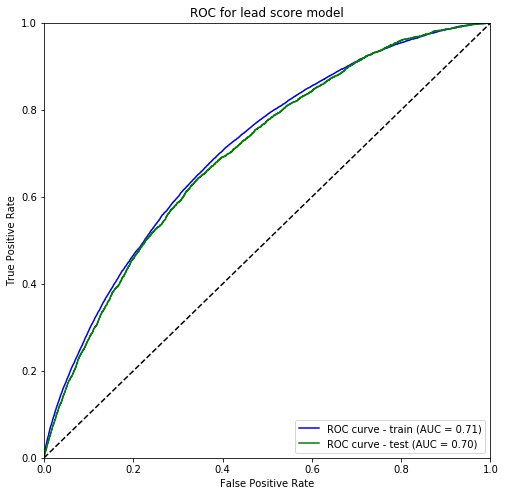

In [259]:
draw_ROC(gbm, xgbtrain, xgbtest, train_y, test_y)

<a id='4.4'></a>
### 4.4 Model performance

This project is to help investors identify the good loans and minimize the exposure of default risk. Thus, we focus the model accuracy on the true positive rate (TPR) and the negative predictive value (NPV). 

* **True positive rate (TPR)** is also called recall, or sensitivity, which measures the proportion of actual default loans that are correctly identified as such. 

* **Negative predictive value (NPV)** is the proportions of of predicted non-default loans that are really non-default loans.

That is to say, if we label loans with probability of default higher than 0.10 as "bad" loans, our model can correctly idenfity 78.6% of the bad loans, and at the same time, 93.3% of the loans that are labeled as "good" loans are real non-default loans.

In [260]:
test_y_prob = gbm.predict(xgbtest, ntree_limit=gbm.best_ntree_limit)

* The following table shows the performance metrics under different thresholds:

In [261]:
# List different thresholds for probability of default to label the bad loans
for prob in np.arange(0.05, 0.50, 0.05):
    test_y_pred = [1 if pred>prob else 0 for pred in test_y_prob]
    conf_mat = metrics.confusion_matrix(test_y, test_y_pred)
    TPR = conf_mat[1,1]/(conf_mat[1,1]+conf_mat[1,0]) 
    NPV = conf_mat[0,0]/(conf_mat[0,0]+conf_mat[1,0]) 
    PPV = conf_mat[1,1]/(conf_mat[0,1]+conf_mat[1,1])
    f1 = 2/(1/TPR+1/PPV)
    print('Threshold: %.2f, Recall: %.4f, Precision: %.4f, NPV: %.4f, f1-score: %4f' %(prob, TPR, PPV, NPV, f1))

Threshold: 0.05, Recall: 0.9685, Precision: 0.1595, NPV: 0.9694, f1-score: 0.273940
Threshold: 0.10, Recall: 0.7859, Precision: 0.2004, NPV: 0.9327, f1-score: 0.319428
Threshold: 0.15, Recall: 0.5794, Precision: 0.2450, NPV: 0.9112, f1-score: 0.344386
Threshold: 0.20, Recall: 0.3811, Precision: 0.2880, NPV: 0.8929, f1-score: 0.328113
Threshold: 0.25, Recall: 0.2207, Precision: 0.3263, NPV: 0.8787, f1-score: 0.263339
Threshold: 0.30, Recall: 0.1073, Precision: 0.3620, NPV: 0.8688, f1-score: 0.165575
Threshold: 0.35, Recall: 0.0437, Precision: 0.3913, NPV: 0.8632, f1-score: 0.078560
Threshold: 0.40, Recall: 0.0158, Precision: 0.4228, NPV: 0.8607, f1-score: 0.030400
Threshold: 0.45, Recall: 0.0052, Precision: 0.6071, NPV: 0.8598, f1-score: 0.010222


<a id='4.5'></a>
### 4.5 Feature importance

In [262]:
importance=gbm.get_fscore()
df_importance = pd.Series(importance).reset_index()
df_importance.columns = ['feature', 'fscore']
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()

In [263]:
# Return the top 10 most important features
df_importance.sort_values(['fscore'], ascending=False, inplace=True)
df_importance[0:10]

,feature,fscore
12,intrate,0.086286
15,loanamount,0.076007
2,annualinc,0.052566
6,dti,0.051164
18,mosinoldrevtlop,0.045947
53,tothicredlim,0.045168
0,accopenpast24mths,0.045090
7,emplength,0.034577
38,pcttlnvrdlq,0.032163
17,mosinoldilacct,0.028269


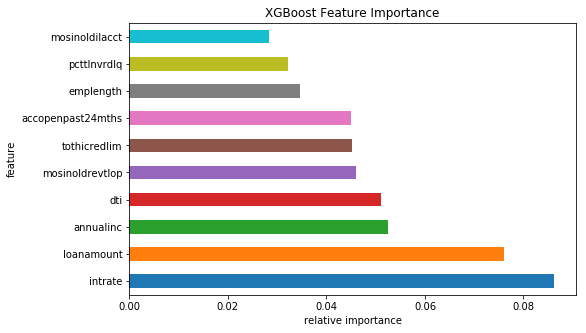

In [423]:
df_importance[:10].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(8, 5))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
#plt.gcf().savefig('feature_importance_xgb.png')

Text(0.5,0,'relative importance')

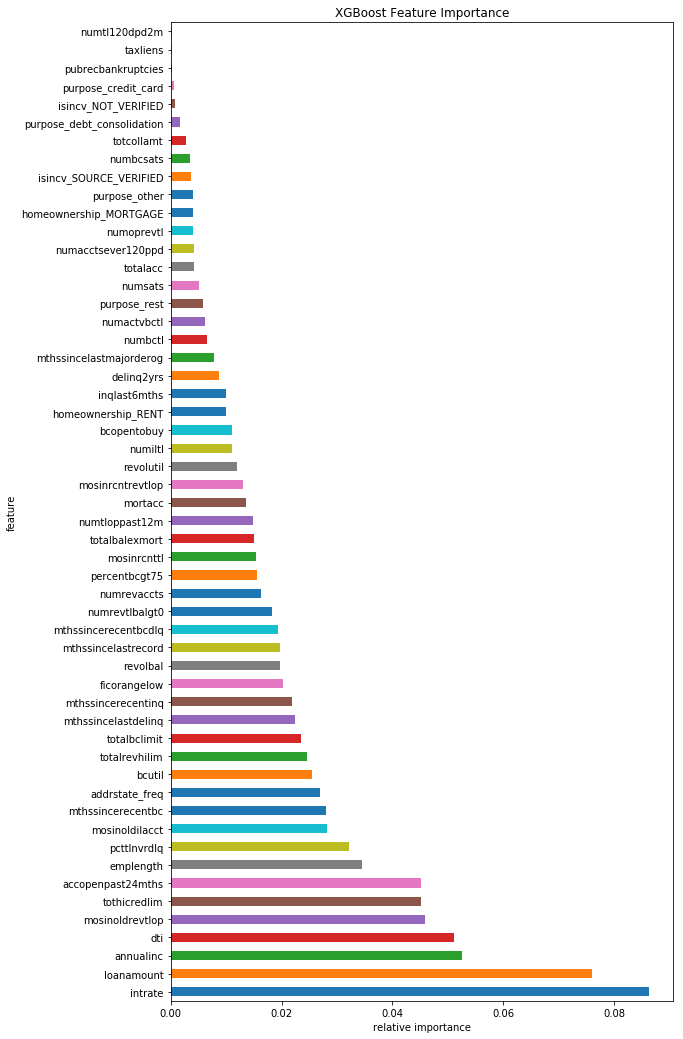

In [265]:
# Plot feature importance for all features
df_importance.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(9, 18))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

<a id='4.6'></a>
### 4.6 Performance on test data

The test dataset contains the loans from November and December 2014. 

In [338]:
df_test['risk'] = test_y_prob

In [455]:
df_test_risk = df_test[['loanstatus', 'grade', 'subgrade', 'intrate', 'loanamount', 'annualinc', 'dti', 'risk']]

In [456]:
df_test_risk.groupby('grade')['grade'].count()

grade
A    5885
B    7000
C    6496
D    2988
E     905
F     134
G      17
Name: grade, dtype: int64

In [468]:
table_100 = pd.DataFrame(columns=['grade', 'sample_100', 'lowest_risk_100'])
for grade in ['A', 'B', 'C', 'D', 'E', 'F']:
    sample = df_test_risk[df_test_risk.grade==grade].sample(100, random_state=20).sum().loc['loanstatus']
    top = df_test_risk[df_test_risk.grade==grade].sort_values(by='risk')[:100].sum().loc['loanstatus']
    fraction = round((1-top/sample)*100, 2)
    table_100 = table_100.append({'grade': grade, 'sample_100': sample, 'lowest_risk_100': top, 'risk_reduced(%)': fraction}, ignore_index=True)

In the following table, under each grade group, 
* **sample_100**: randomly sample 100 loans, and count the number of defaulted loans
* **lowest_risk_100**: choose the top 100 loans with the lowest predicted default risk and count the number of defaulted loans
* **risk_reduced(%)**: the precentage of reduced default risk through the prediction model.

**Clearly, choosing loans based on the predicted default probability can dramatically reduce the default risk.**

In [469]:
table_100

,grade,sample_100,lowest_risk_100,risk_reduced(%)
0,A,5,3,40.00
1,B,10,3,70.00
2,C,16,3,81.25
3,D,23,15,34.78
4,E,33,19,42.42
5,F,37,33,10.81


**The following table chooses 500 loans under each grade group. Again choosing loans based on the predicted default probability can dramatically reduce the default risk.**

In [486]:
table_500 = pd.DataFrame(columns=['grade', 'sample_500', 'lowest_risk_500'])
for grade in ['A', 'B', 'C', 'D', 'E']:
    sample = df_test_risk[df_test_risk.grade==grade].sample(500, random_state=20).sum().loc['loanstatus']
    top = df_test_risk[df_test_risk.grade==grade].sort_values(by='risk')[:500].sum().loc['loanstatus']
    fraction = round((1-top/sample)*100, 2)
    table_500 = table_500.append({'grade': grade, 'sample_500': sample, 'lowest_risk_500': top, 'risk_reduced(%)': fraction}, ignore_index=True)

In [487]:
table_500

,grade,sample_500,lowest_risk_500,risk_reduced(%)
0,A,30,7,76.67
1,B,59,28,52.54
2,C,83,50,39.76
3,D,112,84,25.00
4,E,158,147,6.96


In [488]:
df_test_risk.to_csv('data/df_test_risk_prediction.csv', index=False)

<a id='4.7'></a>
### 4.7 Export trained model

In [266]:
import pickle

In [267]:
pickle.dump(gbm, open('model_xgb_dec.pkl', "wb"))

<a id='5'></a>
## 5. Prediction on Current Loans

After training the historical data, the rest of the code can be used alone for prediction on current loans.

<a id='5.1'></a>
### 5.1  Load the model

In [382]:
# Load the trained model
with open("model_xgb_dec.pkl", 'rb') as pkl_file:
            gbm = pickle.load(pkl_file)

<a id='5.2'></a>
### 5.2  Load current loan data

LendingClub updates new loans on their platform four times a day. Here we use a timestamp to note the time we pull the loan data and perform the prediction.

In [383]:
# This is the timestamp of the new loans being analyzed in this project
print(str(datetime.now()))

2018-07-30 22:57:54.867999


In [384]:
api_key =open('apikey.txt','r').read()

headers = {'Authorization':api_key}
url='https://api.lendingclub.com/api/investor/v1/loans/listing?showAll=true'

r=requests.get(url, headers=headers)

In [385]:
data=r.json()
df_curr = pd.io.json.json_normalize(data['loans'])
df_curr.shape

(396, 119)

<a id='5.3'></a>
### 5.3  Data cleaning

In [386]:
# Change column names to lowercase
df_curr.columns = map(str.lower, df_curr.columns)

In [387]:
# Choose applicationtype= individual and term=36, since the model is trained on these assumptions
df_curr = df_curr[(df_curr.applicationtype=='INDIVIDUAL') & (df_curr.term==36)]
df_curr.shape

(318, 119)

In [388]:
addrstate_freq = pd.read_csv('data/model_addrstate_freq.csv')
df_curr = pd.merge(df_curr, addrstate_freq, how = "left", on = "addrstate")

In [389]:
# Re-group the "purpose" feature
purpose_cat = ['credit_card', 'debt_consolidation', 'home_improvement', 'other']
df_curr.loc[~df_curr.purpose.isin(purpose_cat), 'purpose'] = 'rest'

In [390]:
# Perform One-Hot-Encoding on these three categorical features
fn_obj = ['homeownership', 'isincv', 'purpose']
df_dummy = pd.get_dummies(df_curr[fn_obj])
df_curr = pd.concat([df_curr, df_dummy], axis=1 )

In [391]:
fn_OHE_curr = list(df_dummy.columns.values)

In [392]:
# OHE features from the training dataset
fn_OHE_hist = ['homeownership_MORTGAGE',
 'homeownership_OWN',
 'homeownership_RENT',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_home_improvement',
 'purpose_other',
 'purpose_rest',
 'isincv_NOT_VERIFIED',
 'isincv_SOURCE_VERIFIED',
 'isincv_VERIFIED']

In [393]:
# Check if there are missing OHE features from the current dataset
fn_add = list(set(fn_OHE_hist)-set(fn_OHE_curr))
fn_add

[]

In [394]:
# If there are missing OHE features, add them to df_curr and give all values 0
for feature in fn_add:
    df_curr[feature] = 0

<a id='5.4'></a>
### 5.4 Predict the default rate 

In [395]:
test_x = df_curr[gbm.feature_names].copy()

In [396]:
test_x.shape

(318, 64)

In [397]:
xgbtest = xgb.DMatrix(test_x, missing=np.nan)

In [398]:
test_y_pred = gbm.predict(xgbtest, ntree_limit=gbm.best_ntree_limit)

<a id='5.5'></a>
### 5.5 Recommend loans based on investors' preference

Next we set up a table with most important features and default risk. We also rename features with clear meanings.

In [399]:
df_curr['default_risk'] = test_y_pred
df_curr['amount_to_fund'] = df_curr['loanamount'] - df_curr['fundedamount']

In [400]:
# Investors can add or remove features by their preference.
top_features = {
 'id': 'id',
 'grade': 'grade',
 'subgrade': 'subgrade',
 'dti': 'dti',
 'annualinc': 'annual_income',
 'emplength': 'employment_length',
 'addrstate': 'state',
 'intrate': 'interest_rate',
 'loanamount': 'loan_amount',
 'amount_to_fund': 'amount_to_fund',
 'default_risk': 'default_risk'
}

In [401]:
df_curr_pred = df_curr[list(top_features.keys())]
df_curr_pred.columns = list(top_features.values())

In [402]:
df_curr_pred.head()

,id,grade,subgrade,dti,annual_income,employment_length,state,interest_rate,loan_amount,amount_to_fund,default_risk
0,137323185,A,A4,28.59,50000.0,24.0,IL,7.84,4000.0,50.0,0.080042
1,137444107,D,D4,20.70,60000.0,36.0,NJ,20.89,8375.0,75.0,0.317653
2,137348940,C,C2,13.90,60000.0,84.0,AZ,14.47,4000.0,200.0,0.127061
3,135039365,A,A1,9.07,120000.0,72.0,CA,5.31,22000.0,12775.0,0.044723
4,137270497,E,E1,21.59,90000.0,120.0,CA,23.40,5200.0,725.0,0.142401


Now investors can filter the table with their own preferences.

#### Scenario 1: Choose loans with interest rate higher than 10%, and list loans by ascending order of default risk 

In [403]:
df_curr_pred[df_curr_pred.interest_rate>10].sort_values(by='default_risk').head(10)

,id,grade,subgrade,dti,annual_income,employment_length,state,interest_rate,loan_amount,amount_to_fund,default_risk
180,137776334,B,B2,12.04,168520.0,120.0,MO,10.47,8000.0,6050.0,0.038396
186,137344295,B,B1,14.23,62000.0,120.0,NV,10.08,11000.0,6375.0,0.052286
279,137736682,B,B1,16.99,88000.0,240.0,NJ,10.08,25000.0,18350.0,0.067795
134,137742742,B,B2,6.71,37000.0,12.0,FL,10.47,5000.0,2925.0,0.068120
246,137665096,B,B3,12.62,120000.0,216.0,MD,11.06,26000.0,12700.0,0.068246
141,137530038,B,B4,25.21,97000.0,84.0,OH,11.55,5600.0,3200.0,0.075742
87,137377578,B,B1,1.92,40000.0,120.0,TX,10.08,35000.0,21725.0,0.081852
164,137226822,B,B3,12.97,48000.0,144.0,CA,11.06,15000.0,5000.0,0.082181
184,137488736,B,B2,19.95,90000.0,96.0,GA,10.47,20000.0,6225.0,0.085019
222,137746289,B,B3,15.53,83000.0,48.0,CA,11.06,20000.0,9700.0,0.085403


#### Scenario 2: Choose loans with grade "C" and remove loans from CA or FL

In [404]:
df_curr_pred[(df_curr_pred.grade=='C') & (~df_curr_pred.state.isin(['CA', 'FL']))].sort_values(by='default_risk').head(10)

,id,grade,subgrade,dti,annual_income,employment_length,state,interest_rate,loan_amount,amount_to_fund,default_risk
90,137460419,C,C1,13.00,48000.0,12.0,OR,13.56,10000.0,5225.0,0.096534
127,137661847,C,C2,17.18,140000.0,36.0,SC,14.47,12275.0,2450.0,0.097036
219,137629305,C,C2,8.10,160000.0,36.0,IL,14.47,16500.0,9550.0,0.110733
158,137723355,C,C1,17.15,55000.0,36.0,TX,13.56,10000.0,4725.0,0.125261
140,137649345,C,C2,7.51,45888.0,120.0,CT,14.47,10000.0,3150.0,0.126692
2,137348940,C,C2,13.90,60000.0,84.0,AZ,14.47,4000.0,200.0,0.127061
266,137326866,C,C4,25.23,130000.0,120.0,NY,16.14,25000.0,15600.0,0.128588
260,137686995,C,C2,22.87,90000.0,60.0,AL,14.47,27000.0,14550.0,0.130894
252,137630408,C,C2,17.27,95000.0,120.0,MO,14.47,16000.0,13550.0,0.131547
122,137227213,C,C2,21.14,102000.0,60.0,OH,14.47,10000.0,1950.0,0.134427
